In [1]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob
logging.getLogger().setLevel('INFO')

In [2]:
import numpy as np
from IPython.display import display, HTML

import matplotlib
matplotlib.use("cairo")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

%matplotlib inline

## Helpers

In [3]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [ ]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)
WTA_DIR = './{}/WTA'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]
WTA_URLS = [BASE_URL + "/%iw/%i.zip" % (i,i) for i in range(2007,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)
os.makedirs(osp.join(WTA_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS, ATP_DIR), (WTA_URLS, WTA_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))
WTA_FILES = sorted(glob("%s/*.xls*" % WTA_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)
df_wta = pd.concat([pd.read_excel(f) for f in WTA_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])
logging.info("%i matches WTA in df_wta", df_wta.shape[0])

In [ ]:
df_atp.to_csv("df_atp.csv")
df_wta.to_csv("df_wta.csv")

#### If the dataset is already available

In [3]:
df_atp = pd.read_csv("df_atp.csv", index_col=0, low_memory=False)
df_atp["Date"] = pd.to_datetime(df_atp["Date"])

df_atp.head(5)

,ATP,AvgL,AvgW,B&WL,B&WW,B365L,B365W,Best of,CBL,CBW,...,UBW,W1,W2,W3,W4,W5,WPts,WRank,Winner,Wsets
0,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,6.0,6.0,NaN,NaN,NaN,NaN,63,Dosedel S.,2.0
1,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,6.0,6.0,NaN,NaN,NaN,NaN,5,Enqvist T.,2.0
2,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,6.0,7.0,6.0,NaN,NaN,NaN,40,Escude N.,2.0
3,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,6.0,6.0,NaN,NaN,NaN,NaN,65,Federer R.,2.0
4,1,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,...,NaN,7.0,5.0,6.0,NaN,NaN,NaN,81,Fromberg R.,2.0


## Your work

### Helper Functions

In [4]:
def mutual_hist(data1, data1_name, data1_color, data2, data2_name, data2_color, x_label, y_label, title):
    """
    Plot overlaid histograms of two distributions
    """
    # Set the bounds for the bins so that the two distributions are fairly compared
    max_nbins = 10
    data_range = [min(min(data1), min(data2)), max(max(data1), max(data2))]
    binwidth = (data_range[1] - data_range[0]) / max_nbins
    bins = np.arange(data_range[0], data_range[1] + binwidth, binwidth)

    # Create the plot
    _, ax = plt.subplots()
    ax.hist(data1, bins = bins, color = data1_color, alpha = 1, label = data1_name)
    ax.hist(data2, bins = bins, color = data2_color, alpha = 0.75, label = data2_name)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.legend(loc = 'best')

### Q1. The three (3) ATP players with most wins

In [5]:
df_atp.groupby("Winner").size().sort_values(ascending=False).head(3)

# .groupby : Creates groups each holding rows with unique column value
# .size    : Returns size of each group
# .sort_values : Sorts the Panda Series (actually in descending order)
# .head        : Returns the N foremost elements

Winner
Federer R.     1108
Nadal R.        891
Djokovic N.     789
dtype: int64

### Q2. The number of sets won by Roger Federer

In [6]:
# We filter the ATP dataframe to get Federer's matches
# To do so, we need to make sure that our research is case-insensitive
# Also we could use regular expressions

df_federer = df_atp[df_atp["Winner"].str.contains('federer', case=False)]
sets_won = int(df_federer["Wsets"].sum())

display(HTML("<h4>The number of sets won in total by R. Federer is : {} sets".format(sets_won)))

### Q3. The number of sets won by Roger Federer in 2016 and 2017

In [7]:
# For 2016 only
sets_won_2016 = df_federer[df_federer["Date"].dt.year == 2016]["Wsets"].sum()
sets_won_2016 = int(sets_won_2016)

# For 2017 only
sets_won_2017 = df_federer[df_federer["Date"].dt.year == 2017]["Wsets"].sum()
sets_won_2017 = int(sets_won_2017)

# For both 2016 and 2017 (For the sake of using multiple filtering criterias)
sets_won_2016_2017 = df_federer[(df_federer["Date"].dt.year == 2016) | (df_federer["Date"].dt.year == 2017)]["Wsets"].sum()
sets_won_2016_2017 = int(sets_won_2016_2017)

display(HTML("<h4>The number of sets won in 2016 by R. Federer is : {} sets".format(sets_won_2016)))
display(HTML("<h4>The number of sets won in 2017 by R. Federer is : {} sets".format(sets_won_2017)))
display(HTML("<h4>The number of sets won in 2016 and 2017 by R. Federer is : {} sets".format(sets_won_2016_2017)))

## Q4. Percentage of winner victories prior to each match

###### The solution to this question is computationally extensive
- We try to solve this issue by either parallelizing the Pandas' `apply` method using a library (e.g. Dask).
- Or, we adopt C-compiled code using Cython (Actual solution)

In [8]:
%load_ext Cython

In [9]:
%%cython
cpdef double prior_wins_percentage(date, str player, df, int min_games=5):
    """
    Calculate the percentage of a player's wins prior to a given date
    
    @arg date (Datetime) : The reference date
    @arg player (str) : Player's name
    @arg df (pd.DataFrame) : Pandas Dataframe holding the games date
    @arg min_games (int) : Used to avoid extra-high win rates (e.g. like at a professional career debut)
    
    @return Floating number between 0.0 and 1.0 representing the actual wins percentage
    """
    cpdef df_prior;
    cdef int prior_wins;
    cdef int prior_losses;
    
    df_prior = df[df["Date"] < date]
    prior_wins = df_prior[df_prior["Winner"] == player].shape[0]
    prior_losses = df_prior[df_prior["Loser"] == player].shape[0]
    
    # We set a minimum number of games to avoid extra-high win rates
    # (e.g. like at a professional career debut)
    if (prior_wins + prior_losses) < min_games:
        return 0
    return prior_wins / (prior_wins + prior_losses)

#### Calculate the match winner's prior wins precentage

In [ ]:
df_atp["winner_prior_wins"] = df_atp.apply(
    lambda row: prior_wins_percentage(
        row["Date"],
        row["Winner"],
        df_atp
    ),
    axis=1
)

#### Calculate the match loser's prior wins percentage
This will be a useful feature for our classification.

In [ ]:
df_atp["loser_prior_wins"] = df_atp.apply(
    lambda row: prior_wins_percentage(
        row["Date"],
        row["Loser"],
        df_atp
    ),
    axis=1
)

###### Save to a local CSV file

In [10]:
# df_atp.to_csv("atp_prior_wins.csv")

df_atp = pd.read_csv("atp_prior_wins.csv", index_col=0, low_memory=False)
df_atp["Date"] = pd.to_datetime(df_atp["Date"])

### Plotting the distribution of prior wins percentages of each opponent

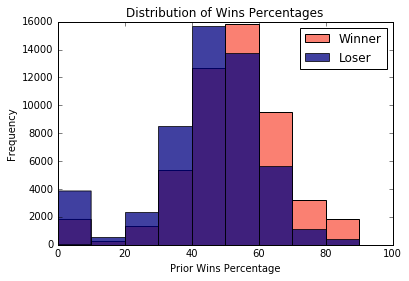

In [11]:
mutual_hist(data1 = df_atp["winner_prior_wins"].apply(lambda x: x * 100)
                   , data1_name = 'Winner'
                   , data1_color = 'salmon'
                   , data2 = df_atp["loser_prior_wins"].apply(lambda x: x * 100)
                   , data2_name = 'Loser'
                   , data2_color = 'navy'
                   , x_label = 'Prior Wins Percentage'
                   , y_label = 'Frequency'
                   , title = 'Distribution of Wins Percentages')

display(HTML("<h4>Here, nothing new : Winners tend to win and losers tend to lose. Nature stikes again."))

### Plotting the Career Progress of Top 3 ATP Players

In [12]:
df_top3 = df_atp[
    (df_atp["Winner"].str.contains("federer", case=False)) | \
    (df_atp["Winner"].str.contains("nadal", case=False)) | \
    (df_atp["Winner"].str.contains("djokovic", case=False))
][["Winner", "Date", "winner_prior_wins"]]

df_top3 = df_top3.drop(df_top3[df_top3["winner_prior_wins"] == 0.0].index)

In [13]:
x_date = []
y_federer = []
y_nadal = []
y_djokovic = []

for date, group in df_top3.groupby(["Date"]):
    x_date.append(date)
    try:
        y_federer.append(group[group["Winner"].str.contains("federer", case=False)].iloc[0]["winner_prior_wins"])
    except IndexError:
        y_federer.append(y_federer[-1] if len(y_federer) else 0.0)
    try:
        y_nadal.append(group[group["Winner"].str.contains("nadal", case=False)].iloc[0]["winner_prior_wins"])
    except IndexError:
        y_nadal.append(y_nadal[-1] if len(y_nadal) else 0.0)
    try:
        y_djokovic.append(group[group["Winner"].str.contains("djokovic", case=False)].iloc[0]["winner_prior_wins"])
    except IndexError:
        y_djokovic.append(y_djokovic[-1] if len(y_djokovic) else 0.0)

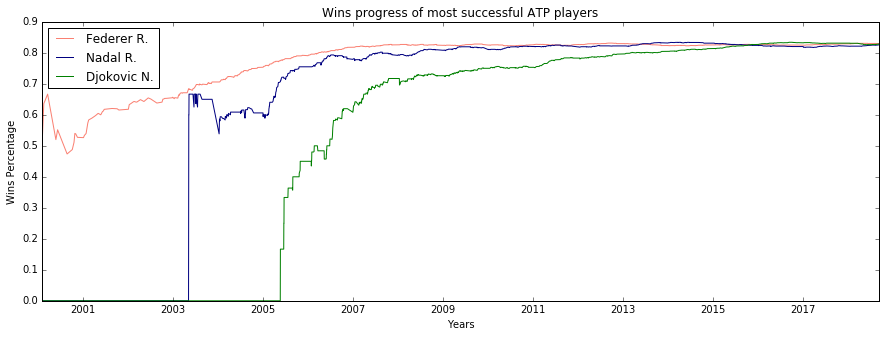

In [14]:
plt.figure(figsize=(15, 5))

plt.plot(x_date, y_federer, color='salmon', label="Federer R.")
plt.plot(x_date, y_nadal, color='navy', label="Nadal R.")
plt.plot(x_date, y_djokovic, color='green', label="Djokovic N.")
plt.title("Wins progress of most successful ATP players")
plt.xlabel("Years")
plt.ylabel("Wins Percentage")
plt.legend(loc='best');

## Features Extraction & Selection

We set Player 1 as the player who's name alphabetically comes first.

Then, we set the labels as :
- 1 -> if Player 1 wins
- 0 -> if Player 1 loses

In [15]:
df_atp["Labels"] = df_atp.apply(lambda row: 1 if row["Winner"] < row["Loser"] else 0, axis=1)
display(df_atp[["Winner", "Loser", "Labels"]].head(5))

display(HTML("<h4>The number of 1's : {}".format(df_atp[df_atp["Labels"] == 1].shape[0])))
display(HTML("<h4>The number of 0's : {}".format(df_atp[df_atp["Labels"] == 0].shape[0])))
display(HTML("<h4>We notice that there is no Imbalanced Data issue !"))

,Winner,Loser,Labels
0,Dosedel S.,Ljubicic I.,1
1,Enqvist T.,Clement A.,0
2,Escude N.,Baccanello P.,0
3,Federer R.,Knippschild J.,1
4,Fromberg R.,Woodbridge T.,1


### Dropping features that are intuitively irrelevant

In [16]:
df_feat = df_atp.loc[:, ['AvgL', 'AvgW', 'B&WL', 'B&WW', 'B365L', 'B365W', 'CBL', 'CBW', 'EXL', 'EXW', 'GBL', 'GBW', \
    'IWL', 'IWW', 'L1', 'L2', 'L3', 'L4', 'L5', 'LBL', 'LBW', 'LRank', 'Lsets', 'MaxL', 'MaxW', 'PSL', 'PSW', \
    'SBL', 'SBW', 'SJL', 'SJW', 'UBL', 'UBW', 'W1', 'W2', 'W3', 'W4', 'W5', 'WRank', 'Wsets', \
    'winner_prior_wins', 'loser_prior_wins', "Date", 'Labels']]

### Dealing with NaNs
- We first convert values that are objects to float representation
- Second, we drop columns where all values are NaNs
- Then, we fill NaN values with the following strategy :
    - For odds, we replace NaNs by a value of 1.0 which corresponds to a winning probability of 50% (For an odd X/Y, the winning probability is given by `p = Y / (X + Y)`)
    - For number of games won by set, we replace NaNs by zeros, supposing that the match is won before arriving to this set
    - For number of sets won during the match `Wsets` and `Lsets`, we suppose that the NaN values correspond to a withdrawal (e.g. due to injury), so we replace that by zeros
    - For Player's rank, we fill with the maximum rank value in each column
    

In [17]:
display(HTML("<h4>Counting the NaN values for each feature :"))
df_feat.isnull().sum()

AvgL                 29553
AvgW                 29553
B&WL                 50879
B&WW                 50879
B365L                 8631
B365W                 8654
CBL                  34470
CBW                  34470
EXL                  12881
EXW                  12886
GBL                  46921
GBW                  46921
IWL                  38618
IWW                  38618
L1                     255
L2                     763
L3                   27918
L4                   47245
L5                   50185
LBL                  24030
LBW                  24041
LRank                   78
Lsets                  219
MaxL                 29553
MaxW                 29553
PSL                  14958
PSW                  14958
SBL                  46552
SBW                  46552
SJL                  36397
SJW                  36404
UBL                  41305
UBW                  41305
W1                     257
W2                     764
W3                   27917
W4                   47245
W

#### Casting Datetimes to floats

In [18]:
df_feat["Date"] = pd.to_numeric(df_feat["Date"], downcast='float')

####  We then convert object values to numerical values to be able to fit them into our models

In [19]:
object_cols = df_feat.columns[df_feat.dtypes.eq(object)]
df_feat.loc[:, object_cols] = df_feat.apply(pd.to_numeric, errors='coerce')    # "coerce" means replacing errors by NaNs

#### Now we fill NaNs according to the aforementioned strategy

In [20]:
df_feat = df_feat.dropna(axis=1, how="all")

df_feat.fillna({x : 1.0 for x in [
    "AvgL", "AvgW", "B&WL", "B&WW", "B365L", "B365W", "CBL", "CBW", "EXL", "EXW", "GBL", "GBW", "IWL", "IWW",
    "LBL", "LBW", "MaxL", "MaxW", "PSL", "PSW", "SBL", "SBW", "SJL", "SJW", "UBL", "UBW"
]}, inplace=True);

df_feat.fillna({x : 0 for x in [
    "L1", "L2", "L3", "L4", "L5", "W1", "W2", "W3", "W4", "W5", "Lsets", "Wsets"
]}, inplace=True);

df_feat["WRank"] = df_feat["WRank"].fillna(df_feat["WRank"].max())
df_feat["LRank"] = df_feat["LRank"].fillna(df_feat["LRank"].max())

### Most Relevant Features

We use a Random Forest Classifier to find the features relevance in our classification problem

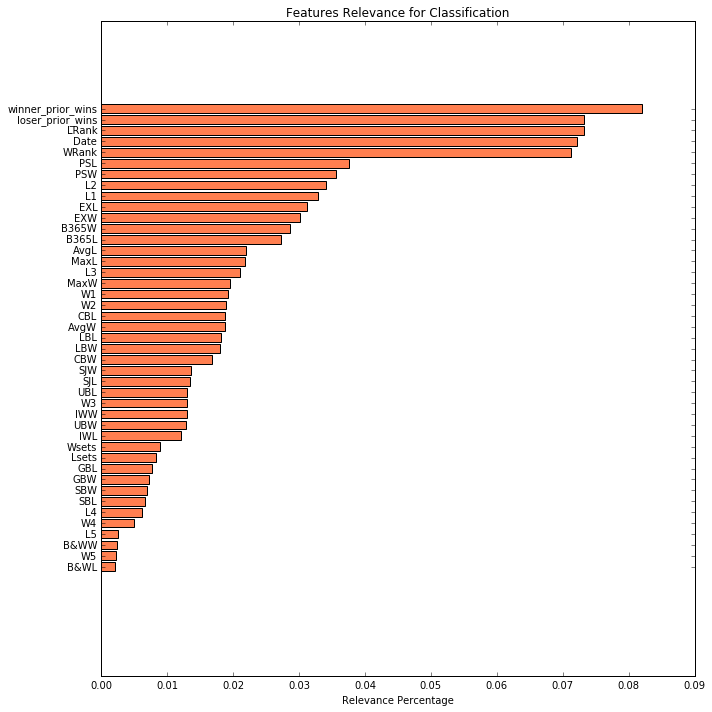

In [21]:
from sklearn.ensemble import RandomForestClassifier

feat_forest = RandomForestClassifier(n_jobs=-1)
feat_forest.fit(X=df_feat.drop("Labels", axis=1), y=df_feat.loc[:, "Labels"])

plt.figure(figsize=(10, 10))
feat_imp = feat_forest.feature_importances_
cols = df_feat.columns

feat_imp, cols = zip(*sorted(zip(feat_imp, cols)))

plt.barh(range(len(cols)), feat_imp, align="center", color='coral');
plt.yticks(range(len(cols)), cols)
plt.title("Features Relevance for Classification")
plt.xlabel("Relevance Percentage")
plt.tight_layout();

#### We set a minimum relevance percentage threshold according to which we drop features

In [22]:
relevance_threshold = 0.025
feat_imp = np.array(feat_imp)
most_relevante_feat = cols[- np.where(feat_imp > relevance_threshold)[0].shape[0] :]

most_relevante_feat

('B365L',
 'B365W',
 'EXW',
 'EXL',
 'L1',
 'L2',
 'PSW',
 'PSL',
 'WRank',
 'Date',
 'LRank',
 'loser_prior_wins',
 'winner_prior_wins')

In [23]:
df_feat = df_feat[[*(most_relevante_feat + ("Labels",))]]
df_feat.head(5)

,B365L,B365W,EXW,EXL,L1,L2,PSW,PSL,WRank,Date,LRank,loser_prior_wins,winner_prior_wins,Labels
0,1.0,1.0,1.0,1.0,4.0,2.0,1.0,1.0,63.0,9.468576e+17,77.0,0.0,0.0,1
1,1.0,1.0,1.0,1.0,3.0,3.0,1.0,1.0,5.0,9.468576e+17,56.0,0.0,0.0,0
2,1.0,1.0,1.0,1.0,7.0,5.0,1.0,1.0,40.0,9.468576e+17,655.0,0.0,0.0,0
3,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,65.0,9.468576e+17,87.0,0.0,0.0,1
4,1.0,1.0,1.0,1.0,6.0,7.0,1.0,1.0,81.0,9.468576e+17,198.0,0.0,0.0,1


## Data Viz

#### Opponents Previous Wins Percentages

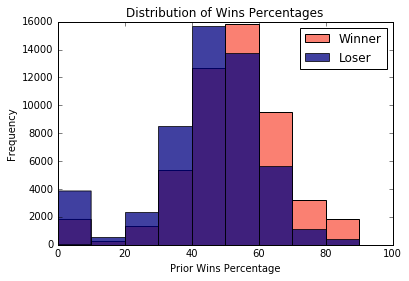

In [24]:
mutual_hist(data1 = df_feat["winner_prior_wins"].apply(lambda x: x * 100)
                   , data1_name = 'Winner'
                   , data1_color = 'salmon'
                   , data2 = df_feat["loser_prior_wins"].apply(lambda x: x * 100)
                   , data2_name = 'Loser'
                   , data2_color = 'navy'
                   , x_label = 'Prior Wins Percentage'
                   , y_label = 'Frequency'
                   , title = 'Distribution of Wins Percentages')

display(HTML("<h4>We notice that match winners tend to have more prior wins then their opponent. In other words winners keep winning and losers don't."))

#### Opponents ATP Ranking Distribution

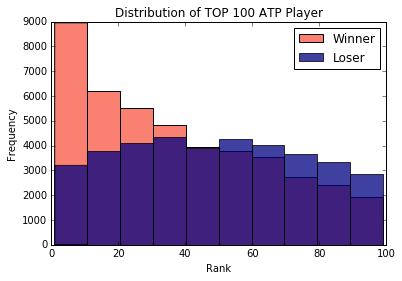

In [25]:
mutual_hist(data1 = df_feat[df_feat["WRank"] < 100]["WRank"]
                   , data1_name = 'Winner'
                   , data1_color = 'salmon'
                   , data2 = df_feat[df_feat["LRank"] < 100]["LRank"]
                   , data2_name = 'Loser'
                   , data2_color = 'navy'
                   , x_label = 'Rank'
                   , y_label = 'Frequency'
                   , title = 'Distribution of TOP 100 ATP Player')

#### Opponenet's Pinnacles Odds

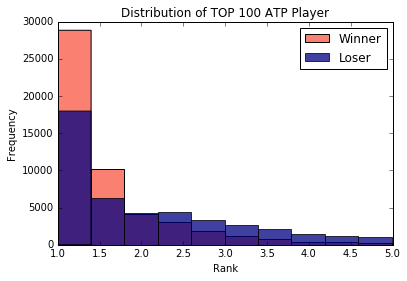

In [26]:
mutual_hist(data1 = df_feat[df_feat["PSW"] < 5.0]["PSW"]
                   , data1_name = 'Winner'
                   , data1_color = 'salmon'
                   , data2 = df_feat[df_feat["PSL"] < 5.0]["PSL"]
                   , data2_name = 'Loser'
                   , data2_color = 'navy'
                   , x_label = 'Rank'
                   , y_label = 'Frequency'
                   , title = 'Distribution of TOP 100 ATP Player')

display(HTML("<h4>We take Pinnacles' odds because they are well known to be more relevante."))
display(HTML("<h4>The winner odds are smaller, which means a bigger win probability according to the relation P = Y / (X + Y), where the odds are X/Y"))

### Standardize the Data

In [27]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer

scaler = StandardScaler()

df_feat[[*most_relevante_feat]] = pd.DataFrame(
    scaler.fit_transform(df_feat.drop(["Labels"], axis=1)),
    columns=most_relevante_feat)

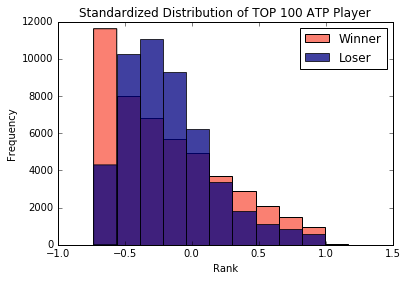

In [28]:
mutual_hist(data1 = df_feat[df_feat["WRank"] < 1]["WRank"]
                   , data1_name = 'Winner'
                   , data1_color = 'salmon'
                   , data2 = df_feat[df_feat["LRank"] < 1]["LRank"]
                   , data2_name = 'Loser'
                   , data2_color = 'navy'
                   , x_label = 'Rank'
                   , y_label = 'Frequency'
                   , title = 'Standardized Distribution of TOP 100 ATP Player')

## Training Day

#### Splitting the dataset to train / test datasets

In [29]:
test_year = 2017

df_train = df_feat.iloc[df_atp[df_atp["Date"].dt.year != test_year].index]
df_test = df_feat.iloc[df_atp[df_atp["Date"].dt.year == test_year].index]

X_train = df_train.drop(["Labels"], axis=1)
y_train = df_train["Labels"]

X_test = df_test.drop(["Labels"], axis=1)
y_test = df_test["Labels"]

### Evaluating multiple classification algorithms

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from time import time

#### Helpers

In [31]:
def classification_report(y_true, y_pred, name_classifiers, train_time=None):
    """
    Displays multiple evaluation metrics for each classifier
    """
    assert(len(y_pred) == len(name_classifiers))
    assert(len(train_time) == len(name_classifiers) if train_time else True)
    
    reports = []
    metrics = ["Classifier", "Accuracy", "Precision", "Recall", "F1-Score"]
    if train_time:
        metrics = metrics + ["Training Duration (seconds)"]

    for idx, y_clf in enumerate(y_pred):
        acc = accuracy_score(y_true, y_clf)
        pre = precision_score(y_true, y_clf)
        rec = recall_score(y_true, y_clf)
        f1s = f1_score(y_true, y_clf)
        report = (name_classifiers[idx], acc, pre, rec, f1s)
        if train_time:
            report = report + (train_time[idx], )
        reports.append(report)
            
    display(pd.DataFrame.from_records(reports, columns=metrics))

### Evaluating most well-known classification algorithms

In [33]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(5, n_jobs=-1),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1),
    MLPClassifier(alpha=0.0001),
    AdaBoostClassifier(),
    GaussianNB()]

y_pred = []
train_time = []

for name, clf in zip(names, classifiers):
    tic = time()
    clf.fit(X_train, y_train)
    toc = time()
    
    y_pred.append(clf.predict(X_train))
    train_time.append(toc - tic)
    
    print("Classifier : {} ===> Training duration : {} sec".format(name, train_time[-1]))

Classifier : Nearest Neighbors ===> Training duration : 0.43830323219299316 sec
Classifier : Linear SVM ===> Training duration : 112.55822229385376 sec
Classifier : RBF SVM ===> Training duration : 923.4305927753448 sec
Classifier : Decision Tree ===> Training duration : 0.46332311630249023 sec
Classifier : Random Forest ===> Training duration : 0.41884684562683105 sec
Classifier : Neural Net ===> Training duration : 13.704818487167358 sec
Classifier : AdaBoost ===> Training duration : 3.216867208480835 sec
Classifier : Naive Bayes ===> Training duration : 0.018457889556884766 sec


In [34]:
classification_report(y_train, y_pred, names, train_time)

,Classifier,Accuracy,Precision,Recall,F1-Score,Training Duration (seconds)
0,Nearest Neighbors,0.696520,0.696600,0.713494,0.704946,0.438303
1,Linear SVM,0.510772,0.509868,0.960392,0.666104,112.558222
2,RBF SVM,0.855637,0.849591,0.869890,0.859620,923.430593
3,Decision Tree,0.601163,0.604399,0.622552,0.613341,0.463323
4,Random Forest,0.639874,0.634664,0.686331,0.659487,0.418847
5,Neural Net,0.549908,0.548484,0.645926,0.593230,13.704818
6,AdaBoost,0.542713,0.553145,0.520601,0.536380,3.216867
7,Naive Bayes,0.515555,0.515992,0.751585,0.611895,0.018458


## Designating the best classifier 

We take as metric the F1-score to have a compromise between precision and recall.

The classifier with best metric evaluation is __the kernelized SVM__

### Evaluation on test data

In [36]:
y_test_pred = []

for name, clf in zip(names, classifiers):
    y_test_pred.append(clf.predict(X_test))

In [37]:
classification_report(y_test, y_test_pred, names)

,Classifier,Accuracy,Precision,Recall,F1-Score
0,Nearest Neighbors,0.517647,0.530747,0.535055,0.532892
1,Linear SVM,0.517647,0.517018,0.941697,0.667539
2,RBF SVM,0.505123,0.517696,0.550554,0.533619
3,Decision Tree,0.583302,0.622265,0.482657,0.543641
4,Random Forest,0.543074,0.553357,0.577860,0.565343
5,Neural Net,0.523340,0.525502,0.752768,0.618932
6,AdaBoost,0.544972,0.576923,0.431734,0.493879
7,Naive Bayes,0.500190,0.511111,0.645018,0.570310


## Further Improvements

- Hyper-parameters tuning (e.g. by splitting the dataset to train/validation/test)

- Modeling Fatigue / Consider time series
    - Add time discount factor to take into account decrease in performance due to phisiological ageing

- Modeling Injury by checking withdrawal from matches

- Improve data validation / cleansing

- Additional Approaches : Build NN with TensorFlow or Keras